# Hole Filling Using Patch-Matching Algorithm

### The formulation of the problem.

Let we have an image $I\in\mathbb{R}^{H\times W\times 3}$ and a binary mask $M\in \{0,1\}^{H\times W}$. Suppose the pixels of $I$ which are marked by $1$ in the binary mask $M$ are unknown, i.e. we do not know the values $I_{ij}$ for every $i,j$ shuch that $M_{ij} = 1$ (and also we know all the values $I_{ij}$ for every $i,j$ such that $M_{ij}=0$).

The problem is $\textbf{to estimate the unknown values of}$ $I$.

###  The algorithm description.
- dilate the binary mask $M$ in order to get the area, from which we need to pick the pixels to fill the hole. The obtained binary mask let's denote by $M_{dil}$
- obtain such binary mask $M_{get}$ that $M_{get}(i,j) = 0 \Longleftrightarrow M(i,j)=0 \; \mbox{and} \; M_{dil}(i,j) = 1$
- for each scale (s = S, S-1, S-2, ..., 1)
    - downscale the image $I$, the mask $M$ and the mask $M_{get}$ to the size $\frac{H}{2^s}\times\frac{W}{2^s}$; let's denote the corresponding downscaled images by $I^s, M^s, M^s_{get}$
    - if s equals to S
        - fill the hole in $I^s$ (described by the mask $M^s$) with the random values $I^s(i,j)$, where $i,j$ are such coordinates that $M^s_{get}(i,j) = 1$. Upscale the obtained image by the factor $2$ and denote the new image by $I'^{s-1}$.
    - else obtain a new $I^s$ as $I^s = M^s \cdot I'^s + (1 - M^s)\cdot I^s$ and for each index $(i,j)$ for which $M^s(i,j)=1$
        - consider the patch $\omega(i,j)$ of $I^s$, centered at $(i,j)$
        - for some iterations, say $20$
            - find the best matching patch $\omega_{best}$ among all patches centered in such indices $(u,v)$ that $M_{get}(u,v) = 1$ (patch-matching is done with the $l_2$ distance between patches)
            - replace the value $I^s(i,j)$ with the center of the patch $\omega_{best}$
        - upscale the obtained image $I^s$ by the factor $2$ and denote the new image by $I'^{s-1}$.
- return the image $I^1$

#### Let's read the image

In [61]:
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

%matplotlib notebook

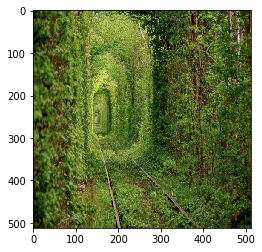

In [2]:
img = cv2.imread('hole_filling.jpg')[:,:,::-1]
img = cv2.resize(img, (512, 512))/ 255.
plt.imshow(img);

#### Let' make a mask to fill

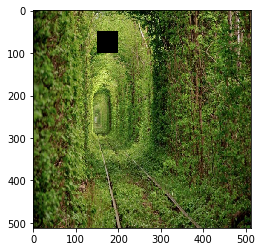

In [3]:
mask_to_fill = np.zeros_like(img[:,:,0])
mask_to_fill[50:100,150:200] = 1.0

# visualize the image with hole
img_with_hole = img.copy()
img_with_hole[np.stack([mask_to_fill]*3, axis = -1) == 1] = 0
plt.imshow(img_with_hole);

### Now let's proceed with the algorithm described above.

#### Get dilated mask and the mask $M_{get}$

In [4]:
kernel = np.ones((41,41), np.uint8)
dilated_mask = cv2.dilate(mask_to_fill, kernel, iterations = 1)# TODO get dilation of the mask with the window sized (21,21)
mask_to_get_patches = dilated_mask - mask_to_fill # TODO get the mask M_{get}

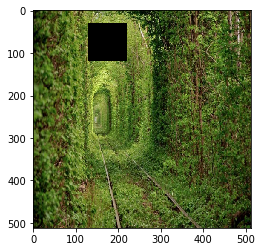

In [5]:
# visualize the image with hole
img_with_hole_test = img.copy()
img_with_hole_test[np.stack([dilated_mask]*3, axis = -1) == 1] = 0
plt.imshow(img_with_hole_test);

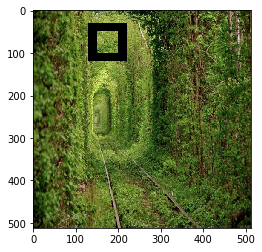

In [6]:
# visualize the image with hole
img_with_hole_test = img.copy()
img_with_hole_test[np.stack([mask_to_get_patches]*3, axis = -1) == 1] = 0
plt.imshow(img_with_hole_test);

#### The main loop

At first let's define the size of the window for patch matching and pad the image with zeros.

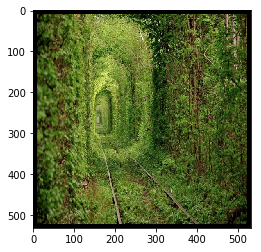

In [7]:
kernel_radius = 10
kernel_size = 2*kernel_radius + 1

img_pad = np.zeros((img.shape[0]+kernel_size-1, img.shape[1]+kernel_size-1, 3))
img_pad[kernel_radius:-kernel_radius, kernel_radius:-kernel_radius,:] = img.copy()

plt.imshow(img_pad);

###  The algorithm description.
- dilate the binary mask $M$ in order to get the area, from which we need to pick the pixels to fill the hole. The obtained binary mask let's denote by $M_{dil}$
- obtain such binary mask $M_{get}$ that $M_{get}(i,j) = 0 \Longleftrightarrow M(i,j)=0 \; \mbox{and} \; M_{dil}(i,j) = 1$
- for each scale (s = S, S-1, S-2, ..., 1)
    - downscale the image $I$, the mask $M$ and the mask $M_{get}$ to the size $\frac{H}{2^s}\times\frac{W}{2^s}$; let's denote the corresponding downscaled images by $I^s, M^s, M^s_{get}$
    - if s equals to S
        - fill the hole in $I^s$ (described by the mask $M^s$) with the random values $I^s(i,j)$, where $i,j$ are such coordinates that $M^s_{get}(i,j) = 1$. Upscale the obtained image by the factor $2$ and denote the new image by $I'^{s-1}$.
    - else obtain a new $I^s$ as $I^s = M^s \cdot I'^s + (1 - M^s)\cdot I^s$ and for each index $(i,j)$ for which $M^s(i,j)=1$
        - consider the patch $\omega(i,j)$ of $I^s$, centered at $(i,j)$
        - for some iterations, say $20$
            - find the best matching patch $\omega_{best}$ among all patches centered in such indices $(u,v)$ that $M_{get}(u,v) = 1$ (patch-matching is done with the $l_2$ distance between patches)
            - replace the value $I^s(i,j)$ with the center of the patch $\omega_{best}$
        - upscale the obtained image $I^s$ by the factor $2$ and denote the new image by $I'^{s-1}$.
- return the image $I^1$

In [34]:
I_res = cv2.resize(img_with_hole, (W//(2**5), H//(2**5)), interpolation=cv2.INTER_NEAREST)

M = cv2.resize(mask_to_fill, (W//(2**5), H//(2**5)), interpolation=cv2.INTER_NEAREST)
M = np.stack([M]*3, axis = -1)

M_get = cv2.resize(mask_to_get_patches, (W//(2**5), H//(2**5)), interpolation=cv2.INTER_NEAREST)
M_get = np.stack([M_get]*3, axis = -1)

In [79]:
# I = img_pad.copy()
I = img.copy()
H, W = img.shape[0], img.shape[1]
# I = cv2.resize(I, (W//(2**5), H//(2**5)))

for s in range(5,1,-1):
    I_res = cv2.resize(img_with_hole, (W//(2**s), H//(2**s)), interpolation=cv2.INTER_NEAREST)
    
    M = cv2.resize(mask_to_fill, (W//(2**s), H//(2**s)), interpolation=cv2.INTER_NEAREST)
    M = np.stack([M]*3, axis = -1)
    
    M_get = cv2.resize(mask_to_get_patches, (W//(2**s), H//(2**s)), interpolation=cv2.INTER_NEAREST)
    M_get = np.stack([M_get]*3, axis = -1)
    
    if s == 5:
        # TODO fill the hole M randomly from the M_get and upscale I at the end
        indices = np.column_stack(np.where(M_get==1))
        for pixel in np.column_stack(np.where(M==1)):
            pixel_choice = random.choice(indices)
            I_res[pixel[0], pixel[1], pixel[2]] = I_res[pixel_choice[0], pixel_choice[1], pixel_choice[2]]
        I = cv2.resize(I_res, (W, H))
    else:
        # TODO define below the main function "fill_the_hole"
        I_res = M * I + (1-M)*I_res
        print(I_res.shape)
        break
#         for _ in range(20):
#             I_res = fill_the_hole()

ValueError: operands could not be broadcast together with shapes (32,32,3) (512,512,3) 

Now let's define the main function ```fill_the_hole```

###  The algorithm description.
- dilate the binary mask $M$ in order to get the area, from which we need to pick the pixels to fill the hole. The obtained binary mask let's denote by $M_{dil}$
- obtain such binary mask $M_{get}$ that $M_{get}(i,j) = 0 \Longleftrightarrow M(i,j)=0 \; \mbox{and} \; M_{dil}(i,j) = 1$
- for each scale (s = S, S-1, S-2, ..., 1)
    - downscale the image $I$, the mask $M$ and the mask $M_{get}$ to the size $\frac{H}{2^s}\times\frac{W}{2^s}$; let's denote the corresponding downscaled images by $I^s, M^s, M^s_{get}$
    - if s equals to S
        - fill the hole in $I^s$ (described by the mask $M^s$) with the random values $I^s(i,j)$, where $i,j$ are such coordinates that $M^s_{get}(i,j) = 1$. Upscale the obtained image by the factor $2$ and denote the new image by $I'^{s-1}$.
    - else obtain a new $I^s$ as $I^s = M^s \cdot I'^s + (1 - M^s)\cdot I^s$ and for each index $(i,j)$ for which $M^s(i,j)=1$
        - consider the patch $\omega(i,j)$ of $I^s$, centered at $(i,j)$
        - for some iterations, say $20$
            - find the best matching patch $\omega_{best}$ among all patches centered in such indices $(u,v)$ that $M_{get}(u,v) = 1$ (patch-matching is done with the $l_2$ distance between patches)
            - replace the value $I^s(i,j)$ with the center of the patch $\omega_{best}$
        - upscale the obtained image $I^s$ by the factor $2$ and denote the new image by $I'^{s-1}$.
- return the image $I^1$

In [ ]:
def fill_the_hole():
    